# CHAMPS : Predicting molecular properties
### Author: Kamal Pangeni
Ref: https://www.kaggle.com/c/champs-scalar-coupling

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import  matplotlib.pyplot as plt
%matplotlib inline

### import data

In [2]:
df_train = pd.read_csv('train.csv')
df_train.head(2)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570


In [3]:
df_test = pd.read_csv('test.csv')
df_test.head(2)

,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC


In [4]:
# add column that counts number of bonds

In [5]:
def add_num_bond(df):
    df_numbond = df.groupby('molecule_name')['atom_index_0'].count().rename('num_bond').reset_index()
    numbond_dict = pd.Series(df_numbond['num_bond'].values,index=df_numbond['molecule_name'].values).to_dict()
    df['num_bond'] = df['molecule_name'].map(numbond_dict)
    
    return df
df_train = add_num_bond(df_train)
df_test = add_num_bond(df_test)

In [6]:
df_train.head(2)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,num_bond
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,10
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,10


In [7]:
df_test.head(2)

,id,molecule_name,atom_index_0,atom_index_1,type,num_bond
0,4658147,dsgdb9nsd_000004,2,0,2JHC,5
1,4658148,dsgdb9nsd_000004,2,1,1JHC,5


In [8]:
def build_pivottable(df,index,columns,values,train=True):
    '''
    -make pivot table
    -for training set, put train=True
    '''
    df_temp = pd.DataFrame()
    df_temp = df[[index,columns,values]]
    df_pivot = df_temp.pivot_table(index =index,columns=columns,
                               values=values, aggfunc=np.sum,fill_value=0)

    return df_pivot

In [9]:
def add_num_bond_pertype(df):
    df_numbond_pertype = df.groupby(['molecule_name','type']
                                     )['atom_index_0'].count().rename('num_bond_pertype').reset_index()
    df_pivot = build_pivottable(df_numbond_pertype,'molecule_name','type','num_bond_pertype')
    df = pd.merge(df,df_pivot,how='left',on='molecule_name')
    
    return df
df_train = add_num_bond_pertype(df_train)
df_test = add_num_bond_pertype(df_test)

In [10]:
df_train.head(2)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,num_bond,1JHC,1JHN,2JHC,2JHH,2JHN,3JHC,3JHH,3JHN
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,10,4,0,0,6,0,0,0,0
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,10,4,0,0,6,0,0,0,0


In [11]:
df_test.head(2)

,id,molecule_name,atom_index_0,atom_index_1,type,num_bond,1JHC,1JHN,2JHC,2JHH,2JHN,3JHC,3JHH,3JHN
0,4658147,dsgdb9nsd_000004,2,0,2JHC,5,2,0,2,0,0,0,1,0
1,4658148,dsgdb9nsd_000004,2,1,1JHC,5,2,0,2,0,0,0,1,0


In [12]:
# data exploration

In [13]:
df_train['type'].value_counts()

3JHC    1510379
2JHC    1140674
1JHC     709416
3JHH     590611
2JHH     378036
3JHN     166415
2JHN     119253
1JHN      43363
Name: type, dtype: int64

In [14]:
import seaborn as sns

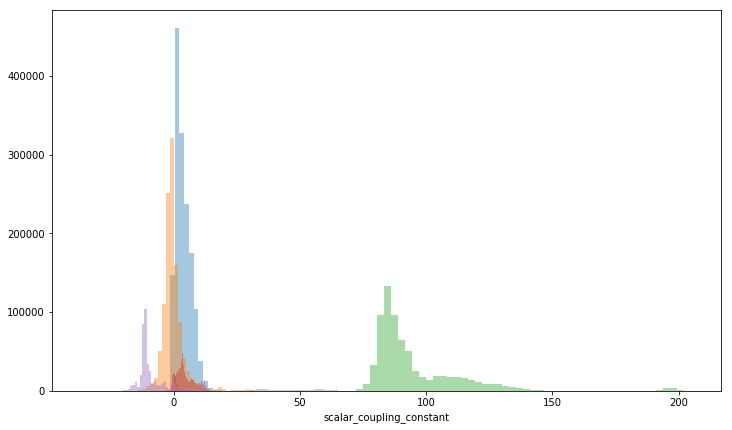

In [15]:
plt.figure(figsize=(12,7))
sns.distplot(df_train[df_train['type']=='3JHC']['scalar_coupling_constant'],kde=False)
sns.distplot(df_train[df_train['type']=='2JHC']['scalar_coupling_constant'],kde=False)
sns.distplot(df_train[df_train['type']=='1JHC']['scalar_coupling_constant'],kde=False)
sns.distplot(df_train[df_train['type']=='3JHH']['scalar_coupling_constant'],kde=False)
sns.distplot(df_train[df_train['type']=='2JHH']['scalar_coupling_constant'],kde=False)
sns.distplot(df_train[df_train['type']=='3JHN']['scalar_coupling_constant'],kde=False)
sns.distplot(df_train[df_train['type']=='2JHN']['scalar_coupling_constant'],kde=False)
sns.distplot(df_train[df_train['type']=='1JHN']['scalar_coupling_constant'],kde=False)
plt.show()

In [16]:
df_test['type'].value_counts()

3JHC    811999
2JHC    613138
1JHC    380609
3JHH    317435
2JHH    203126
3JHN     90616
2JHN     64424
1JHN     24195
Name: type, dtype: int64

In [17]:
structures = pd.read_csv('structures.csv')
structures.head(2)

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976


In [18]:
## combine dataframes
df_train_wstr = pd.merge(df_train,structures.rename(columns={'atom_index':'atom_index_0','atom':'atom_0','x':'x0','y':'y0','z':'z0'}),
              on=['molecule_name','atom_index_0'],how='left')

In [19]:
## combine dataframes
df_test_wstr = pd.merge(df_test,structures.rename(columns={'atom_index':'atom_index_0','atom':'atom_0','x':'x0','y':'y0','z':'z0'}),
              on=['molecule_name','atom_index_0'],how='left')

In [20]:
df_train_wstr.head(2)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,num_bond,1JHC,1JHN,2JHC,2JHH,2JHN,3JHC,3JHH,3JHN,atom_0,x0,y0,z0
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,10,4,0,0,6,0,0,0,0,H,0.00215,-0.006031,0.001976
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,10,4,0,0,6,0,0,0,0,H,0.00215,-0.006031,0.001976


In [21]:
df_test_wstr.head(2)

,id,molecule_name,atom_index_0,atom_index_1,type,num_bond,1JHC,1JHN,2JHC,2JHH,2JHN,3JHC,3JHH,3JHN,atom_0,x0,y0,z0
0,4658147,dsgdb9nsd_000004,2,0,2JHC,5,2,0,2,0,0,0,1,0,H,-1.661639,0.0,1.0
1,4658148,dsgdb9nsd_000004,2,1,1JHC,5,2,0,2,0,0,0,1,0,H,-1.661639,0.0,1.0


In [22]:
# further merging of dataframes
df_train_wstr1 = pd.merge(df_train_wstr,structures.rename(columns={'atom_index':'atom_index_1','atom':'atom_1','x':'x1','y':'y1','z':'z1'}),
              on=['molecule_name','atom_index_1'],how='left')

In [23]:
# further merging of dataframes
df_test_wstr1 = pd.merge(df_test_wstr,structures.rename(columns={'atom_index':'atom_index_1','atom':'atom_1','x':'x1','y':'y1','z':'z1'}),
              on=['molecule_name','atom_index_1'],how='left')

In [24]:
df_train_wstr1.head(2)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,num_bond,1JHC,1JHN,2JHC,...,3JHH,3JHN,atom_0,x0,y0,z0,atom_1,x1,y1,z1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,10,4,0,0,...,0,0,H,0.00215,-0.006031,0.001976,C,-0.012698,1.085804,0.008001
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,10,4,0,0,...,0,0,H,0.00215,-0.006031,0.001976,H,1.011731,1.463751,0.000277


In [25]:
df_test_wstr1.head(2)

,id,molecule_name,atom_index_0,atom_index_1,type,num_bond,1JHC,1JHN,2JHC,2JHH,...,3JHH,3JHN,atom_0,x0,y0,z0,atom_1,x1,y1,z1
0,4658147,dsgdb9nsd_000004,2,0,2JHC,5,2,0,2,0,...,1,0,H,-1.661639,0.0,1.0,C,0.599539,0.0,1.0
1,4658148,dsgdb9nsd_000004,2,1,1JHC,5,2,0,2,0,...,1,0,H,-1.661639,0.0,1.0,C,-0.599539,0.0,1.0


In [26]:
df_train_final = df_train_wstr1.drop(['atom_index_0','atom_index_1','atom_0','atom_1'],axis=1)

In [27]:
df_train_final.head(2)

,id,molecule_name,type,scalar_coupling_constant,num_bond,1JHC,1JHN,2JHC,2JHH,2JHN,3JHC,3JHH,3JHN,x0,y0,z0,x1,y1,z1
0,0,dsgdb9nsd_000001,1JHC,84.8076,10,4,0,0,6,0,0,0,0,0.00215,-0.006031,0.001976,-0.012698,1.085804,0.008001
1,1,dsgdb9nsd_000001,2JHH,-11.2570,10,4,0,0,6,0,0,0,0,0.00215,-0.006031,0.001976,1.011731,1.463751,0.000277


In [28]:
df_test_final = df_test_wstr1.drop(['atom_index_0','atom_index_1','atom_0','atom_1'],axis=1)

In [29]:
df_test_final.head(2)

,id,molecule_name,type,num_bond,1JHC,1JHN,2JHC,2JHH,2JHN,3JHC,3JHH,3JHN,x0,y0,z0,x1,y1,z1
0,4658147,dsgdb9nsd_000004,2JHC,5,2,0,2,0,0,0,1,0,-1.661639,0.0,1.0,0.599539,0.0,1.0
1,4658148,dsgdb9nsd_000004,1JHC,5,2,0,2,0,0,0,1,0,-1.661639,0.0,1.0,-0.599539,0.0,1.0


In [30]:
df_train_final.head()

,id,molecule_name,type,scalar_coupling_constant,num_bond,1JHC,1JHN,2JHC,2JHH,2JHN,3JHC,3JHH,3JHN,x0,y0,z0,x1,y1,z1
0,0,dsgdb9nsd_000001,1JHC,84.8076,10,4,0,0,6,0,0,0,0,0.002150,-0.006031,0.001976,-0.012698,1.085804,0.008001
1,1,dsgdb9nsd_000001,2JHH,-11.2570,10,4,0,0,6,0,0,0,0,0.002150,-0.006031,0.001976,1.011731,1.463751,0.000277
2,2,dsgdb9nsd_000001,2JHH,-11.2548,10,4,0,0,6,0,0,0,0,0.002150,-0.006031,0.001976,-0.540815,1.447527,-0.876644
3,3,dsgdb9nsd_000001,2JHH,-11.2543,10,4,0,0,6,0,0,0,0,0.002150,-0.006031,0.001976,-0.523814,1.437933,0.906397
4,4,dsgdb9nsd_000001,1JHC,84.8074,10,4,0,0,6,0,0,0,0,1.011731,1.463751,0.000277,-0.012698,1.085804,0.008001


In [31]:
df_test_final.head()

,id,molecule_name,type,num_bond,1JHC,1JHN,2JHC,2JHH,2JHN,3JHC,3JHH,3JHN,x0,y0,z0,x1,y1,z1
0,4658147,dsgdb9nsd_000004,2JHC,5,2,0,2,0,0,0,1,0,-1.661639,0.0,1.0,0.599539,0.0,1.0
1,4658148,dsgdb9nsd_000004,1JHC,5,2,0,2,0,0,0,1,0,-1.661639,0.0,1.0,-0.599539,0.0,1.0
2,4658149,dsgdb9nsd_000004,3JHH,5,2,0,2,0,0,0,1,0,-1.661639,0.0,1.0,1.661639,0.0,1.0
3,4658150,dsgdb9nsd_000004,1JHC,5,2,0,2,0,0,0,1,0,1.661639,0.0,1.0,0.599539,0.0,1.0
4,4658151,dsgdb9nsd_000004,2JHC,5,2,0,2,0,0,0,1,0,1.661639,0.0,1.0,-0.599539,0.0,1.0


In [32]:
# convert categorical to dummies
#df_train_final_wdummies = pd.get_dummies(df_train_final,columns=['type'],drop_first=False)
#df_test_final_wdummies = pd.get_dummies(df_test_final,columns=['type'],drop_first=False)

df_train_final_wdummies = df_train_final
df_test_final_wdummies = df_test_final

In [33]:
df_train_final_wdummies.head()

,id,molecule_name,type,scalar_coupling_constant,num_bond,1JHC,1JHN,2JHC,2JHH,2JHN,3JHC,3JHH,3JHN,x0,y0,z0,x1,y1,z1
0,0,dsgdb9nsd_000001,1JHC,84.8076,10,4,0,0,6,0,0,0,0,0.002150,-0.006031,0.001976,-0.012698,1.085804,0.008001
1,1,dsgdb9nsd_000001,2JHH,-11.2570,10,4,0,0,6,0,0,0,0,0.002150,-0.006031,0.001976,1.011731,1.463751,0.000277
2,2,dsgdb9nsd_000001,2JHH,-11.2548,10,4,0,0,6,0,0,0,0,0.002150,-0.006031,0.001976,-0.540815,1.447527,-0.876644
3,3,dsgdb9nsd_000001,2JHH,-11.2543,10,4,0,0,6,0,0,0,0,0.002150,-0.006031,0.001976,-0.523814,1.437933,0.906397
4,4,dsgdb9nsd_000001,1JHC,84.8074,10,4,0,0,6,0,0,0,0,1.011731,1.463751,0.000277,-0.012698,1.085804,0.008001


In [34]:
df_test_final_wdummies.head()

,id,molecule_name,type,num_bond,1JHC,1JHN,2JHC,2JHH,2JHN,3JHC,3JHH,3JHN,x0,y0,z0,x1,y1,z1
0,4658147,dsgdb9nsd_000004,2JHC,5,2,0,2,0,0,0,1,0,-1.661639,0.0,1.0,0.599539,0.0,1.0
1,4658148,dsgdb9nsd_000004,1JHC,5,2,0,2,0,0,0,1,0,-1.661639,0.0,1.0,-0.599539,0.0,1.0
2,4658149,dsgdb9nsd_000004,3JHH,5,2,0,2,0,0,0,1,0,-1.661639,0.0,1.0,1.661639,0.0,1.0
3,4658150,dsgdb9nsd_000004,1JHC,5,2,0,2,0,0,0,1,0,1.661639,0.0,1.0,0.599539,0.0,1.0
4,4658151,dsgdb9nsd_000004,2JHC,5,2,0,2,0,0,0,1,0,1.661639,0.0,1.0,-0.599539,0.0,1.0


In [41]:
df_train_final_wdummies[df_train_final_wdummies['x1']==df_train_final_wdummies['x0']]

,id,molecule_name,type,scalar_coupling_constant,num_bond,1JHC,1JHN,2JHC,2JHH,2JHN,3JHC,3JHH,3JHN,x0,y0,z0,x1,y1,z1
1871038,1871038,dsgdb9nsd_059818,2JHH,-13.0987,57,11,0,11,7,2,14,6,6,2.571505,-0.886511,-2.50124,2.571505,0.886511,-2.50124


In [42]:
df_train_final_wdummies['tan_phi'] = df_train_final_wdummies.apply(lambda x: (x['y1']-x['y0'])/(x['x1']-x['x0']+0.000001),axis=1)

In [43]:
df_train_final_wdummies['l2'] = df_train_final_wdummies.apply(lambda x:(x['x0']-x['x1'])**2+(x['y0']-x['y1'])**2+(x['z0']-x['z1'])**2
                                                            ,axis=1)

In [44]:
df_train_final_wdummies['cos_theta'] = df_train_final_wdummies.apply(lambda x: (x['z1']-x['z0'])/(x['l2']),axis=1)

In [45]:
df_train_final_wdummies['dist_x'] = df_train_final_wdummies.apply(lambda x:(x['x0']-x['x1']),axis=1)
df_train_final_wdummies['dist_y'] = df_train_final_wdummies.apply(lambda x:(x['y0']-x['y1']),axis=1)
df_train_final_wdummies['dist_z'] = df_train_final_wdummies.apply(lambda x:(x['z0']-x['z1']),axis=1)

In [46]:
df_test_final_wdummies['tan_phi'] = df_test_final_wdummies.apply(lambda x: (x['y1']-x['y0'])/(x['x1']-x['x0']+0.000001),axis=1)

In [47]:
df_test_final_wdummies['l2'] = df_test_final_wdummies.apply(lambda x:(x['x0']-x['x1'])**2+(x['y0']-x['y1'])**2+(x['z0']-x['z1'])**2
                                                            ,axis=1)

In [48]:
df_test_final_wdummies['cos_theta'] = df_test_final_wdummies.apply(lambda x: (x['z1']-x['z0'])/(x['l2']),axis=1)

In [49]:
df_test_final_wdummies['dist_x'] = df_test_final_wdummies.apply(lambda x:(x['x0']-x['x1']),axis=1)
df_test_final_wdummies['dist_y'] = df_test_final_wdummies.apply(lambda x:(x['y0']-x['y1']),axis=1)
df_test_final_wdummies['dist_z'] = df_test_final_wdummies.apply(lambda x:(x['z0']-x['z1']),axis=1)

In [50]:
df_test_final_wdummies.head(10)

,id,molecule_name,type,num_bond,1JHC,1JHN,2JHC,2JHH,2JHN,3JHC,...,z0,x1,y1,z1,tan_phi,l2,cos_theta,dist_x,dist_y,dist_z
0,4658147,dsgdb9nsd_000004,2JHC,5,2,0,2,0,0,0,...,1.000000,0.599539,0.000000,1.000000,0.000000,5.112926,0.000000,-2.261178,0.000000,0.000000
1,4658148,dsgdb9nsd_000004,1JHC,5,2,0,2,0,0,0,...,1.000000,-0.599539,0.000000,1.000000,0.000000,1.128054,0.000000,-1.062099,0.000000,0.000000
2,4658149,dsgdb9nsd_000004,3JHH,5,2,0,2,0,0,0,...,1.000000,1.661639,0.000000,1.000000,0.000000,11.044171,0.000000,-3.323277,0.000000,0.000000
3,4658150,dsgdb9nsd_000004,1JHC,5,2,0,2,0,0,0,...,1.000000,0.599539,0.000000,1.000000,-0.000000,1.128054,0.000000,1.062099,0.000000,0.000000
4,4658151,dsgdb9nsd_000004,2JHC,5,2,0,2,0,0,0,...,1.000000,-0.599539,0.000000,1.000000,-0.000000,5.112926,0.000000,2.261178,0.000000,0.000000
5,4658152,dsgdb9nsd_000015,1JHC,18,6,0,0,6,0,6,...,0.004656,-0.014821,1.392412,0.005671,0.409513,1.215127,0.000835,1.020105,0.417746,-0.001015
6,4658153,dsgdb9nsd_000015,3JHC,18,6,0,0,6,0,6,...,0.004656,0.637949,-0.553297,-1.113582,6.434082,6.971311,-0.160406,0.367335,2.363455,1.118239
7,4658154,dsgdb9nsd_000015,2JHH,18,6,0,0,6,0,6,...,0.004656,-0.546896,1.793435,-0.872511,0.010774,3.178961,-0.275929,1.552179,0.016723,0.877167
8,4658155,dsgdb9nsd_000015,2JHH,18,6,0,0,6,0,6,...,0.004656,-0.530029,1.722920,0.911017,0.056821,3.186285,0.284457,1.535313,0.087238,-0.906361
9,4658156,dsgdb9nsd_000015,1JHC,18,6,0,0,6,0,6,...,-0.872511,-0.014821,1.392412,0.005671,-0.753696,1.215125,0.722709,-0.532074,0.401023,-0.878182


#### model training and prediction

In [51]:
def scorer(df):
    score = 0
    T = len(df['type'].unique())
    df1 = pd.DataFrame(columns=df.columns)
    for bond_type in df['type'].unique():
        df_mini = df[df['type']==bond_type]
        df1 = df1.append(df_mini,ignore_index=True)
        score_mini = np.log(mean_absolute_error(df_mini['y_test'],df_mini['y_pred']))
        score = score+score_mini
    score = score/T
    return score   

In [52]:
import xgboost as xgb
from lightgbm import LGBMRegressor

In [53]:
def get_predictions(df,df_test,bond_type,model):
    
    model = model
    bond_type = bond_type
    print(bond_type)
    
    # train data
    df_mini = df[df['type']==bond_type]    
    X = df_mini.drop(['scalar_coupling_constant'],axis=1)
    y = df_mini['scalar_coupling_constant']
    
    #test data
    df_test_mini = df_test[df_test['type']==bond_type]
    X_test_mini = df_test_mini
    
    #train-test split
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

    # scale the data
    scaler = StandardScaler()
    X_train_rs = scaler.fit_transform(X_train.drop(['id','molecule_name','type'],axis=1))
    X_valid_rs = scaler.transform(X_valid.drop(['id','molecule_name','type'],axis=1))
    X_test_rs = scaler.transform(X_test_mini.drop(['id','molecule_name','type'],axis=1))

    #train the model
    model.fit(X_train_rs, y_train,eval_set=[(X_valid_rs,y_valid)],early_stopping_rounds=10,
          eval_metric='mae',verbose=False)
    #model.fit(X_train_rs,y_train)
    pred = model.predict(X_valid_rs)

    # eval
    mae_train = mean_absolute_error(model.predict(X_train_rs), y_train)
    mae_valid = mean_absolute_error(pred, y_valid)
    print('The mae of train is:', mae_train)
    print('The mae of validation is:', mae_valid)

    df_wresult = pd.DataFrame(X_valid[['id','molecule_name','type']].values,
                          columns=['id','molecule_name','type'])
    df_wresult['y_test'] = y_valid.values
    df_wresult['y_pred'] = pred
    
    # validation score
    valid_score = scorer(df_wresult)
    print('validation score :', valid_score)

    pred_test = model.predict(X_test_rs)
    df_submission = pd.DataFrame(columns=['id','scalar_coupling_constant'])
    df_submission['id'] = X_test_mini['id'].values
    df_submission['scalar_coupling_constant'] = pred_test
    
    return mae_train, mae_valid, valid_score, df_submission

### type 1JHC

In [54]:
model_xgb_1 = xgb.XGBRegressor(n_estimators=1500, 
                                  n_jobs = -1, 
                                  tree_method='exact', 
                                  learning_rate=0.01,
                                  subsample=0.7,
                                  colsample_bytree=1,
                                  max_depth=10)

In [55]:
mae_train1, mae_valid1, valid_score1, df_submission_1JHC = get_predictions(df_train_final_wdummies,
                                                                        df_test_final_wdummies,'1JHC',model_xgb_1)

1JHC


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


The mae of train is: 3.1567523683651006
The mae of validation is: 3.4880084350148883
validation score : 1.249330924339362


In [56]:
print('mae_train:', mae_train1,'mae_valid: ',mae_valid1, 'valid_score: ',valid_score1)

mae_train: 3.1567523683651006 mae_valid:  3.4880084350148883 valid_score:  1.249330924339362


In [57]:
# lightgbm

In [58]:
model_lgbm_1 = LGBMRegressor(n_estimators=3500,num_leaves=256)

In [59]:
mae_train1_lgb, mae_valid1_lgb, valid_score1_lgb, df_submission_1JHC_lgb = get_predictions(df_train_final_wdummies,
                                                                        df_test_final_wdummies,'1JHC',model_lgbm_1)

1JHC


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


The mae of train is: 1.2683575721370195
The mae of validation is: 2.950668978171779
validation score : 1.0820319169044057


In [60]:
print('mae_train:', mae_train1_lgb,'mae_valid: ',mae_valid1_lgb, 'valid_score: ',valid_score1_lgb)

mae_train: 1.2683575721370195 mae_valid:  2.950668978171779 valid_score:  1.0820319169044057


In [144]:
# ensembling
df_submission_1JHC['final_scalar_coupling'] = 0.5*df_submission_1JHC['scalar_coupling_constant']+0.5*df_submission_1JHC_lgb['scalar_coupling_constant']

### type 2JHC

In [61]:
model_xgb_2 = xgb.XGBRegressor(n_estimators=1500, 
                                  n_jobs = -1, 
                                  tree_method='exact', 
                                  learning_rate=0.01,
                                  subsample=0.7,
                                  colsample_bytree=1,
                                  max_depth=15)

In [62]:
mae_train2, mae_valid2, valid_score2, df_submission_2JHC = get_predictions(df_train_final_wdummies,
                                                                           df_test_final_wdummies,'2JHC',model_xgb_2)

2JHC


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


The mae of train is: 1.008741458408577
The mae of validation is: 1.603499461349264
validation score : 0.4721884042291352


In [63]:
print('mae_train:', mae_train2,'mae_valid: ',mae_valid2, 'valid_score: ',valid_score2)

mae_train: 1.008741458408577 mae_valid:  1.603499461349264 valid_score:  0.4721884042291352


In [64]:
#lightGBM

In [65]:
model_lgbm_2 = LGBMRegressor(n_estimators=3500,num_leaves=256)

In [66]:
mae_train2_lgb, mae_valid2_lgb, valid_score2_lgb, df_submission_2JHC_lgb = get_predictions(df_train_final_wdummies,
                                                                        df_test_final_wdummies,'2JHC',model_lgbm_2)

2JHC


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


The mae of train is: 0.8502029677174894
The mae of validation is: 1.5620718246589933
validation score : 0.44601303285648614


In [67]:
print('mae_train:', mae_train2_lgb,'mae_valid: ',mae_valid2_lgb, 'valid_score: ',valid_score2_lgb)

mae_train: 0.8502029677174894 mae_valid:  1.5620718246589933 valid_score:  0.44601303285648614


In [145]:
# ensembling
df_submission_2JHC['final_scalar_coupling'] = 0.5*df_submission_2JHC['scalar_coupling_constant']+0.5*df_submission_2JHC_lgb['scalar_coupling_constant']

### type 3JHC

In [68]:
model_xgb_3 = xgb.XGBRegressor(n_estimators=1500, 
                                  n_jobs = -1, 
                                  tree_method='exact', 
                                  learning_rate=0.01,
                                  subsample=0.7,
                                  colsample_bytree=1,
                                  max_depth=10)

In [69]:
mae_train3, mae_valid3, valid_score3, df_submission_3JHC = get_predictions(df_train_final_wdummies,
                                                                           df_test_final_wdummies,'3JHC',model_xgb_3)

3JHC


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


The mae of train is: 1.4275539814197629
The mae of validation is: 1.511259137616956
validation score : 0.4129431693252483


In [70]:
print('mae_train:', mae_train3,'mae_valid: ',mae_valid3, 'valid_score: ',valid_score3)

mae_train: 1.4275539814197629 mae_valid:  1.511259137616956 valid_score:  0.4129431693252483


In [71]:
#lightGBM

In [72]:
model_lgbm_3 = LGBMRegressor(n_estimators=3500,num_leaves=256)

In [73]:
mae_train3_lgb, mae_valid3_lgb, valid_score3_lgb, df_submission_3JHC_lgb = get_predictions(df_train_final_wdummies,
                                                                        df_test_final_wdummies,'3JHC',model_lgbm_3)

3JHC


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


The mae of train is: 0.7515820796950408
The mae of validation is: 1.2049589417162199
validation score : 0.1864454930975636


In [74]:
print('mae_train:', mae_train3_lgb,'mae_valid: ',mae_valid3_lgb, 'valid_score: ',valid_score3_lgb)

mae_train: 0.7515820796950408 mae_valid:  1.2049589417162199 valid_score:  0.1864454930975636


In [146]:
# ensembling
df_submission_3JHC['final_scalar_coupling'] = df_submission_3JHC_lgb['scalar_coupling_constant']

### type 3JHH

In [75]:
model_xgb_4 = xgb.XGBRegressor(n_estimators=1500, 
                                  n_jobs = -1, 
                                  tree_method='exact', 
                                  learning_rate=0.01,
                                  subsample=0.8,
                                  colsample_bytree=1,
                                  max_depth=17)

In [76]:
mae_train4, mae_valid4, valid_score4, df_submission_3JHH = get_predictions(df_train_final_wdummies,
                                                                           df_test_final_wdummies,'3JHH',model_xgb_4)

3JHH


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


The mae of train is: 0.25087517958291006
The mae of validation is: 0.8867538307426134
validation score : -0.12018786535734406


In [77]:
print('mae_train:', mae_train4,'mae_valid: ',mae_valid4, 'valid_score: ',valid_score4)

mae_train: 0.25087517958291006 mae_valid:  0.8867538307426134 valid_score:  -0.12018786535734406


In [78]:
#lightGBM

In [79]:
model_lgbm_4 = LGBMRegressor(n_estimators=3000,num_leaves=512)

In [80]:
mae_train4_lgb, mae_valid4_lgb, valid_score4_lgb, df_submission_3JHH_lgb = get_predictions(df_train_final_wdummies,
                                                                        df_test_final_wdummies,'3JHH',model_lgbm_4)

3JHH


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


The mae of train is: 0.16402096833414606
The mae of validation is: 0.8520755790856951
validation score : -0.16008004824006974


In [81]:
print('mae_train:', mae_train4_lgb,'mae_valid: ',mae_valid4_lgb, 'valid_score: ',valid_score4_lgb)

mae_train: 0.16402096833414606 mae_valid:  0.8520755790856951 valid_score:  -0.16008004824006974


In [147]:
# ensembling
df_submission_3JHH['final_scalar_coupling'] = 0.5*df_submission_3JHH['scalar_coupling_constant']+0.5*df_submission_3JHH_lgb['scalar_coupling_constant']

### TYPE 2JHH

In [82]:
model_xgb_5 = xgb.XGBRegressor(n_estimators=1500, 
                                  n_jobs = -1, 
                                  tree_method='exact', 
                                  learning_rate=0.01,
                                  subsample=0.8,
                                  colsample_bytree=1,
                                  max_depth=17)

In [83]:
mae_train5, mae_valid5, valid_score5, df_submission_2JHH = get_predictions(df_train_final_wdummies,
                                                                           df_test_final_wdummies,'2JHH',model_xgb_5)

2JHH


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


The mae of train is: 0.1573337953585569
The mae of validation is: 0.6686945830777146
validation score : -0.4024278506313801


In [84]:
print('mae_train:', mae_train5,'mae_valid: ',mae_valid5, 'valid_score: ',valid_score5)

mae_train: 0.1573337953585569 mae_valid:  0.6686945830777146 valid_score:  -0.4024278506313801


In [85]:
#lightGBM

In [86]:
model_lgbm_5 = LGBMRegressor(n_estimators=2500,num_leaves=256)

In [87]:
mae_train5_lgb, mae_valid5_lgb, valid_score5_lgb, df_submission_2JHH_lgb = get_predictions(df_train_final_wdummies,
                                                                        df_test_final_wdummies,'2JHH',model_lgbm_5)

2JHH


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


The mae of train is: 0.23246524315042413
The mae of validation is: 0.6848876127165056
validation score : -0.3785005232077061


In [88]:
print('mae_train:', mae_train5_lgb,'mae_valid: ',mae_valid5_lgb, 'valid_score: ',valid_score5_lgb)

mae_train: 0.23246524315042413 mae_valid:  0.6848876127165056 valid_score:  -0.3785005232077061


In [148]:
# ensembling
df_submission_2JHH['final_scalar_coupling'] = 0.5*df_submission_2JHH['scalar_coupling_constant']+0.5*df_submission_2JHH_lgb['scalar_coupling_constant']

### type 3JHN

In [89]:
model_xgb_6 = xgb.XGBRegressor(n_estimators=1500, 
                                  n_jobs = -1, 
                                  tree_method='exact', 
                                  learning_rate=0.01,
                                  subsample=0.8,
                                  colsample_bytree=1,
                                  max_depth=17)

In [90]:
mae_train6, mae_valid6, valid_score6, df_submission_3JHN = get_predictions(df_train_final_wdummies,
                                                                           df_test_final_wdummies,'3JHN',model_xgb_6)

3JHN


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


The mae of train is: 0.07832514706666721
The mae of validation is: 0.44323187487381416
validation score : -0.8136622262935324


In [91]:
print('mae_train:', mae_train6,'mae_valid: ',mae_valid6, 'valid_score: ',valid_score6)

mae_train: 0.07832514706666721 mae_valid:  0.44323187487381416 valid_score:  -0.8136622262935324


In [92]:
### lightGBM

In [93]:
model_lgbm_6 = LGBMRegressor(n_estimators=2500,num_leaves=256)

In [94]:
mae_train6_lgb, mae_valid6_lgb, valid_score6_lgb, df_submission_3JHN_lgb = get_predictions(df_train_final_wdummies,
                                                                        df_test_final_wdummies,'3JHN',model_lgbm_6)

3JHN


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


The mae of train is: 0.11677848387334362
The mae of validation is: 0.44945070309872354
validation score : -0.7997291016103568


In [95]:
print('mae_train:', mae_train6_lgb,'mae_valid: ',mae_valid6_lgb, 'valid_score: ',valid_score6_lgb)

mae_train: 0.11677848387334362 mae_valid:  0.44945070309872354 valid_score:  -0.7997291016103568


In [149]:
# ensembling
df_submission_3JHN['final_scalar_coupling'] = 0.5*df_submission_3JHN['scalar_coupling_constant']+0.5*df_submission_3JHN_lgb['scalar_coupling_constant']

### type 2JHN

In [96]:
model_xgb_7 = xgb.XGBRegressor(n_estimators=1500, 
                                  n_jobs = -1, 
                                  tree_method='exact', 
                                  learning_rate=0.01,
                                  subsample=0.8,
                                  colsample_bytree=1,
                                  max_depth=17)

In [97]:
mae_train7, mae_valid7, valid_score7, df_submission_2JHN = get_predictions(df_train_final_wdummies,
                                                                           df_test_final_wdummies,'2JHN',model_xgb_7)

2JHN


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


The mae of train is: 0.09896183588117416
The mae of validation is: 1.0714709843382246
validation score : 0.06903245608581386


In [98]:
print('mae_train:', mae_train7,'mae_valid: ',mae_valid7, 'valid_score: ',valid_score7)

mae_train: 0.09896183588117416 mae_valid:  1.0714709843382246 valid_score:  0.06903245608581386


In [99]:
# lightGBM

In [100]:
model_lgbm_7 = LGBMRegressor(n_estimators=2500,num_leaves=256)

In [101]:
mae_train7_lgb, mae_valid7_lgb, valid_score7_lgb, df_submission_2JHN_lgb = get_predictions(df_train_final_wdummies,
                                                                        df_test_final_wdummies,'2JHN',model_lgbm_7)

2JHN


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


The mae of train is: 0.13040546068344228
The mae of validation is: 1.0614623951304216
validation score : 0.05964757537295688


In [102]:
print('mae_train:', mae_train7_lgb,'mae_valid: ',mae_valid7_lgb, 'valid_score: ',valid_score7_lgb)

mae_train: 0.13040546068344228 mae_valid:  1.0614623951304216 valid_score:  0.05964757537295688


In [150]:
# ensembling
df_submission_2JHN['final_scalar_coupling'] = 0.5*df_submission_2JHN['scalar_coupling_constant']+0.5*df_submission_2JHN_lgb['scalar_coupling_constant']

### type 1JHN

In [103]:
model_xgb_8 = xgb.XGBRegressor(n_estimators=1500, 
                                  n_jobs = -1, 
                                  tree_method='exact', 
                                  learning_rate=0.05,
                                  subsample=0.7,
                                  colsample_bytree=1,
                                  max_depth=8,
                                  min_child_weight=2)

In [104]:
mae_train8, mae_valid8, valid_score8, df_submission_1JHN = get_predictions(df_train_final_wdummies,
                                                                           df_test_final_wdummies,'1JHN',model_xgb_8)

1JHN


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


The mae of train is: 0.74047292848289
The mae of validation is: 1.6292130471716617
validation score : 0.48809710509031523


In [105]:
print('mae_train:', mae_train8,'mae_valid: ',mae_valid8, 'valid_score: ',valid_score8)

mae_train: 0.74047292848289 mae_valid:  1.6292130471716617 valid_score:  0.48809710509031523


In [106]:
#lightGBM

In [107]:
model_lgbm_8 = LGBMRegressor(n_estimators=2500,num_leaves=256)

In [108]:
mae_train8_lgb, mae_valid8_lgb, valid_score8_lgb, df_submission_1JHN_lgb = get_predictions(df_train_final_wdummies,
                                                                        df_test_final_wdummies,'1JHN',model_lgbm_8)

1JHN


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


The mae of train is: 0.2788320308789312
The mae of validation is: 1.5438116788819944
validation score : 0.4342544745276695


In [109]:
print('mae_train:', mae_train8_lgb,'mae_valid: ',mae_valid8_lgb, 'valid_score: ',valid_score8_lgb)

mae_train: 0.2788320308789312 mae_valid:  1.5438116788819944 valid_score:  0.4342544745276695


In [151]:
# ensembling
df_submission_1JHN['final_scalar_coupling'] = 0.5*df_submission_1JHN['scalar_coupling_constant']+0.5*df_submission_1JHN_lgb['scalar_coupling_constant']

In [152]:
###########

In [153]:
df_submission_final = pd.DataFrame(columns=['id','final_scalar_coupling'])

In [154]:
df_submission_final = df_submission_final.append([df_submission_1JHC[['id','final_scalar_coupling']],
                                                  df_submission_1JHN[['id','final_scalar_coupling']],
                                                  df_submission_2JHC[['id','final_scalar_coupling']],
                                                  df_submission_2JHH[['id','final_scalar_coupling']],
                                                  df_submission_2JHN[['id','final_scalar_coupling']],
                                                  df_submission_3JHC[['id','final_scalar_coupling']],
                                                  df_submission_3JHH[['id','final_scalar_coupling']],
                                                  df_submission_3JHN[['id','final_scalar_coupling']]])

In [155]:
df_submission_final.shape

(2505542, 2)

In [156]:
df_submission_final.rename(columns={'final_scalar_coupling':'scalar_coupling_constant'},inplace=True)

In [157]:
df_submission_final[df_submission_final['scalar_coupling_constant'].isnull()]

,id,scalar_coupling_constant


In [158]:
df_submission_final.to_csv('submission.csv',index=False)

### SUBMISSION

In [110]:
# create empty dataframes to store predictions from each type
#df_wresult_final = pd.DataFrame(columns=['id','molecule_name','type','y_test','y_pred'])
df_submission_final = pd.DataFrame(columns=['id','scalar_coupling_constant'])

In [111]:
df_submission_final

,id,scalar_coupling_constant


In [112]:
df_submission_final = df_submission_final.append([df_submission_1JHC_lgb,df_submission_1JHN_lgb,
                                                  df_submission_2JHC_lgb,df_submission_2JHH,
                                                  df_submission_2JHN_lgb,df_submission_3JHC_lgb,
                                                 df_submission_3JHH_lgb,df_submission_3JHN])

In [113]:
df_submission_final.shape

(2505542, 2)

In [114]:
df_submission_final.to_csv('submission.csv',index=False)

In [115]:
df_submission_final.head()

,id,scalar_coupling_constant
0,4658148,194.983720
1,4658150,196.032816
2,4658152,93.439969
3,4658156,92.075857
4,4658159,95.122935
